<a href="https://colab.research.google.com/github/nantmoe-theingi/airbnb-nz-deception-sentiment/blob/main/notebooks/07_reviews_analysis_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
PROJECT_DRIVE_DIR = "/content/drive/MyDrive/Colab Notebooks"

from google.colab import drive
drive.mount('/content/drive')

import os
os.makedirs(PROJECT_DRIVE_DIR, exist_ok=True)
print("Drive project folder:", PROJECT_DRIVE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive project folder: /content/drive/MyDrive/Colab Notebooks


In [121]:
cd {PROJECT_DRIVE_DIR}

/content/drive/MyDrive/Colab Notebooks


In [72]:
import pandas as pd

preds = pd.read_parquet("airbnb_nz_deception_sentiment/outputs/airbnb_predictions.parquet")
print(preds.shape)
print(preds.columns.tolist()[-12:])   # show prediction columns
print(preds[["sent_pred", "deception_pred"]].value_counts().head())

(1533422, 27)
['deception_logit_0', 'deception_logit_1', 'sent_logit_0', 'sent_logit_1', 'sent_logit_2', 'deception_prob_label_0', 'deception_prob_label_1', 'sent_prob_negative', 'sent_prob_neutral', 'sent_prob_positive', 'deception_pred', 'sent_pred']
sent_pred  deception_pred
2          0                 1197587
           1                  269337
1          0                   43173
0          0                   22383
1          1                     787
Name: count, dtype: int64


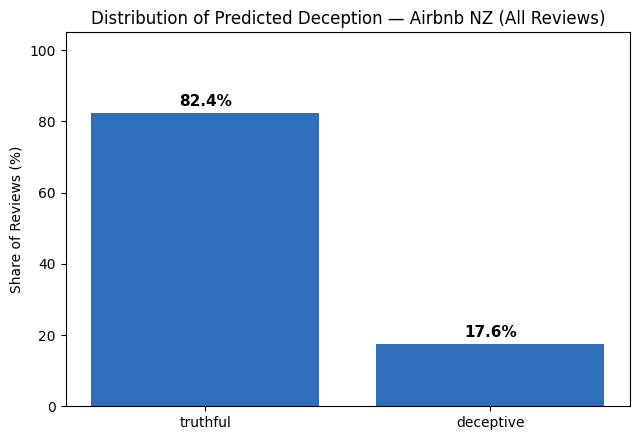

Saved bar chart to airbnb_nz_deception_sentiment/figures/deception_predicted_bar.png


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import os

OUTDIR = "airbnb_nz_deception_sentiment/figures"
os.makedirs(OUTDIR, exist_ok=True)

# preds['deception_pred'] : 0 = truthful, 1 = deceptive

# Count and normalize
counts = preds["deception_pred"].value_counts().sort_index()
share = counts / counts.sum() * 100
labels = ["truthful", "deceptive"]

# Create bar chart
plt.figure(figsize=(6.5, 4.5))
bars = plt.bar(labels, share, color="#2E6EBA")

# 3Add text labels on top of each bar
for bar, pct in zip(bars, share):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="semibold"
    )

# Customize plot style
plt.title("Distribution of Predicted Deception — Airbnb NZ (All Reviews)", fontsize=12)
plt.ylabel("Share of Reviews (%)")
plt.ylim(0, 105)
plt.tight_layout()

# Save figure
out_path = f"{OUTDIR}/deception_predicted_bar.png"
plt.savefig(out_path, dpi=300)
plt.show()
plt.close()

print(f"Saved bar chart to {out_path}")

In [ ]:
# Create a new .py file and open it for editing
file_name = "distribution_deception_sentiment_predictions.py"
with open(file_name, "w") as f:
    f.write("")  # empty file created
print(f"{file_name} created.")

distribution_deception_sentiment_predictions.py created.


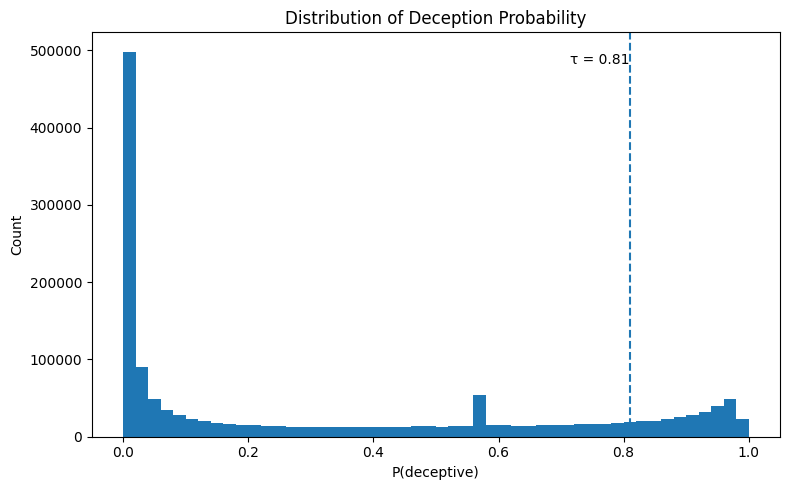

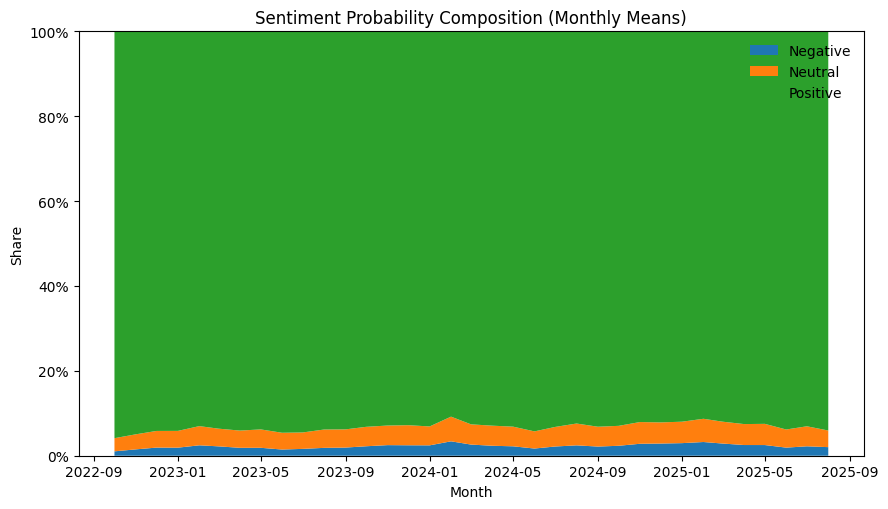

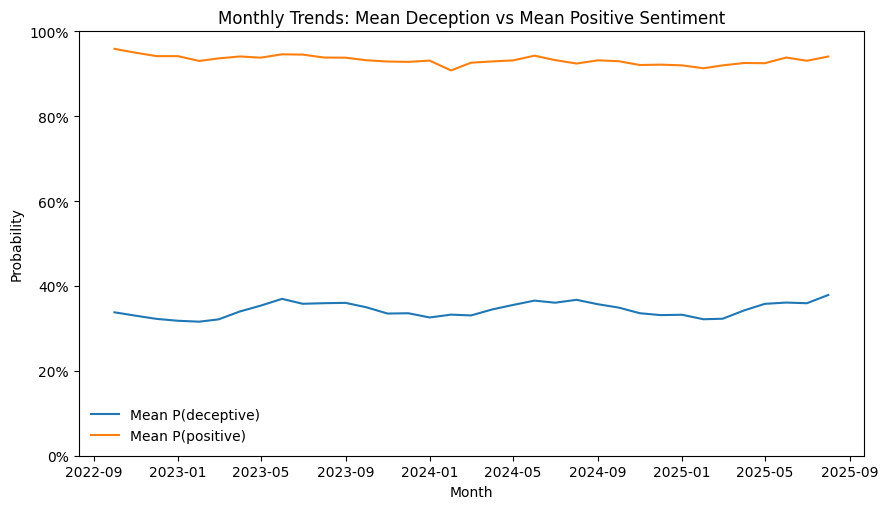

{'deception_hist_png': 'airbnb_nz_deception_sentiment/figures/deception_probability_hist.png',
 'sent_stack_csv': 'airbnb_nz_deception_sentiment/figures/monthly_sentiment_means.csv',
 'sent_stack_png': 'airbnb_nz_deception_sentiment/figures/sentiment_composition_stacked_area.png',
 'dual_csv': 'airbnb_nz_deception_sentiment/figures/monthly_dual_trends.csv',
 'dual_png': 'airbnb_nz_deception_sentiment/figures/monthly_dual_trends.png'}

In [64]:
import pandas as pd
from distribution_deception_sentiment_predictions import (
    run_all,
    plot_deception_histogram,
    plot_monthly_sentiment_stack,
    plot_monthly_dual_trend,
)

outputs_distribution = run_all(preds, outdir="airbnb_nz_deception_sentiment/figures", threshold=0.81)
outputs_distribution

# plot_deception_histogram(preds, outdir="figures", threshold=0.81)
# plot_monthly_sentiment_stack(preds, outdir="figures")
# plot_monthly_dual_trend(preds, outdir="figures")

Saved summary CSV to: airbnb_nz_deception_sentiment/figures/top10_regions_summary.csv


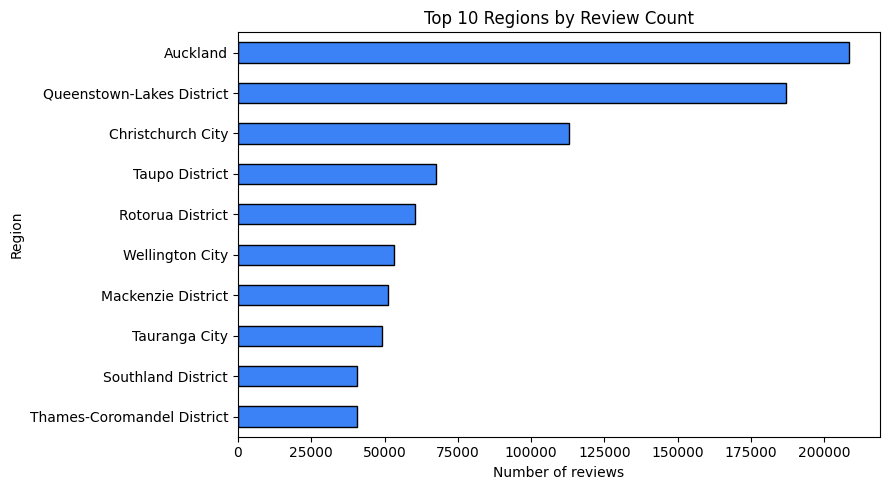

Saved figure to: airbnb_nz_deception_sentiment/figures/top10_regions_bar.png


In [65]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Inputs ---
# preds: DataFrame with at least ['region_name', 'deception_prob_label_1', 'sent_prob_positive']
# Example: preds = pd.read_parquet("outputs/airbnb_predictions.parquet")

OUTDIR = "airbnb_nz_deception_sentiment/figures"
os.makedirs(OUTDIR, exist_ok=True)

def top10_regions_bar(preds: pd.DataFrame,
                      region_col: str = "region",
                      dece_col: str = "deception_prob_label_1",
                      value: str = "count",  # "count" or "mean_deception"
                      csv_path: str = f"{OUTDIR}/top10_regions_summary.csv",
                      fig_path: str = f"{OUTDIR}/top10_regions_bar.png"):
    """
    Plot top 10 regions by review count or mean deception probability.
    """
    df = preds.copy()

    # Drop missing region names
    df = df.dropna(subset=[region_col])

    # Aggregate
    if value == "count":
        agg = df.groupby(region_col).size().sort_values(ascending=False).head(10)
        ylabel = "Number of reviews"
        title = "Top 10 Regions by Review Count"
    elif value == "mean_deception":
        agg = (
            df.groupby(region_col)[dece_col]
            .mean()
            .sort_values(ascending=False)
            .head(10)
        )
        ylabel = "Mean deception probability"
        title = "Top 10 Regions by Mean Deception Probability"
    else:
        raise ValueError("value must be 'count' or 'mean_deception'")

    # Save CSV
    agg.to_csv(csv_path, header=["value"])
    print(f"Saved summary CSV to: {csv_path}")

    # --- Plot ---
    plt.figure(figsize=(9, 5))
    agg.sort_values(ascending=True).plot(kind="barh", color="#3B82F6", edgecolor="black")
    plt.title(title)
    plt.xlabel(ylabel)
    plt.ylabel("Region")
    plt.tight_layout()
    plt.savefig(fig_path, dpi=300)
    plt.show()   # Always display
    plt.close()
    print(f"Saved figure to: {fig_path}")


# Plot top 10 regions by review count
top10_regions_bar(preds, value="count")

# by mean deception probability (after calibration)
# top10_regions_bar(preds, value="mean_deception")

In [70]:
# Create a new .py file and open it for editing
file_name = "analyze_reviewer_credibility.py"
with open(file_name, "w") as f:
    f.write("")  # empty file created
print(f"{file_name} created.")

analyze_reviewer_credibility.py created.


In [ ]:
reviews = pd.read_csv("airbnb_nz_deception_sentiment/data/airbnb_nz_reviews.csv")

Reviewer IDs attached: 1,533,422/1,533,422  (missing: 0)
Saved reviewer credibility table → airbnb_nz_deception_sentiment/figures/reviewer_credibility_table.csv


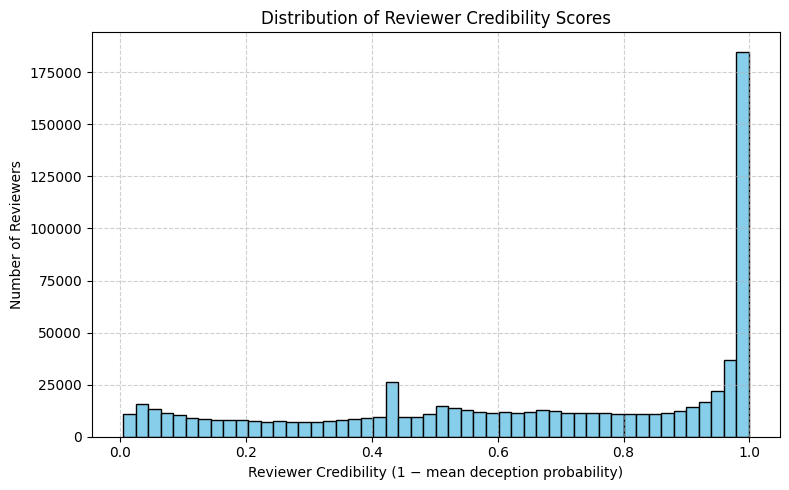

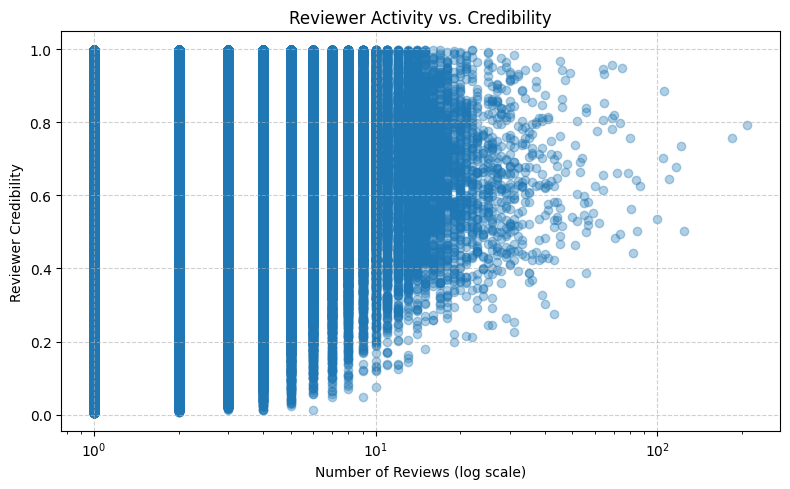

In [78]:
preds["review_id"] = preds["review_id"].astype(str)
reviews["id"] = reviews["id"].astype(str)

from analyze_reviewer_credibility import analyze_reviewer_credibility

df_reviewers = analyze_reviewer_credibility(preds, reviews, outdir="airbnb_nz_deception_sentiment/figures")


In [79]:
# Create a new .py file and open it for editing
file_name = "listing_trust_score.py"
with open(file_name, "w") as f:
    f.write("")  # empty file created
print(f"{file_name} created.")

listing_trust_score.py created.


In [80]:
listings = pd.read_csv("airbnb_nz_deception_sentiment/data/airbnb_nz_listings.csv")

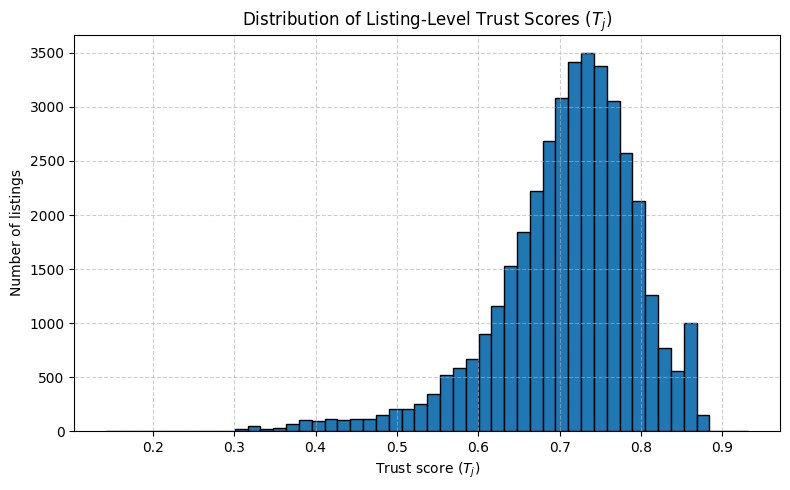

In [84]:
listings["id"] = listings["id"].astype(str)

from listing_trust_score import compute_listing_trust

listing_trust = compute_listing_trust(preds, listings,
                                       outdir="airbnb_nz_deception_sentiment/figures",
                                       sentiment_mode="discrete")  # or "positive_prob"


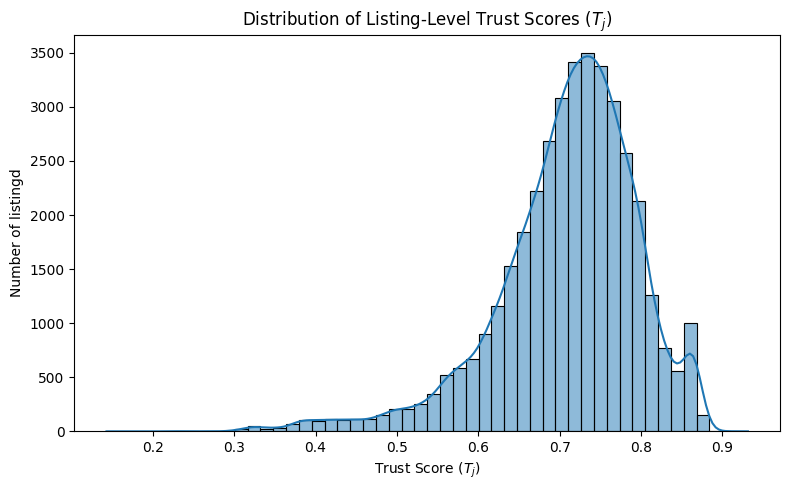

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(listing_trust["T_j"], bins=50, kde=True, edgecolor="black")
plt.title("Distribution of Listing-Level Trust Scores ($T_j$)")
plt.xlabel("Trust Score ($T_j$)")
plt.ylabel("Number of listingd")
plt.tight_layout()
plt.savefig("figures/listing_trust_kde.png", dpi=300)
plt.show()

In [85]:
import pandas as pd

# Sort descending by trust score
top10 = listing_trust.sort_values("T_j", ascending=False).head(10)

# Display summary
display(top10[["listing_id", "D_mean", "S_mean", "B_j", "T_j", "n_reviews"]])

# Compute descriptive stats
print("=== Listing-level Trust Summary ===")
print(f"Total listings: {len(listing_trust):,}")
print(f"Mean Trust (T_j): {listing_trust['T_j'].mean():.3f}")
print(f"Median Trust (T_j): {listing_trust['T_j'].median():.3f}")
print(f"Min Trust (T_j): {listing_trust['T_j'].min():.3f}")
print(f"Max Trust (T_j): {listing_trust['T_j'].max():.3f}")

# Save to CSV for appendix/reference
outpath = "airbnb_nz_deception_sentiment/figures/top10_trustworthy_listings.csv"
top10.to_csv(outpath, index=False)
print(f"\nTop 10 trustworthy listings saved to: {outpath}")

,listing_id,D_mean,S_mean,B_j,T_j,n_reviews
17885,23202521,0.003979,1.000000,0.667641,0.931539,1
8694,1253306225946930116,0.031464,1.000000,0.666862,0.917641,1
4222,1112742787161566382,0.019485,1.000000,0.545683,0.899394,3
33702,792194050434340993,0.007313,1.000000,0.490391,0.894422,1
10171,1288957336012130688,0.048033,1.000000,0.574475,0.890879,28
8932,1259530700610212559,0.096436,1.000000,0.668031,0.885388,6
6363,1179160900303642391,0.020812,1.000000,0.478214,0.885237,17
26478,48147618,0.100779,1.000000,0.676218,0.884854,25
21073,33258727,0.004301,1.000000,0.434193,0.884688,5
16648,20313654,0.073027,0.947368,0.677583,0.883214,19


=== Listing-level Trust Summary ===
Total listings: 39,017
Mean Trust (T_j): 0.709
Median Trust (T_j): 0.721
Min Trust (T_j): 0.143
Max Trust (T_j): 0.932

Top 10 trustworthy listings saved to: airbnb_nz_deception_sentiment/figures/top10_trustworthy_listings.csv


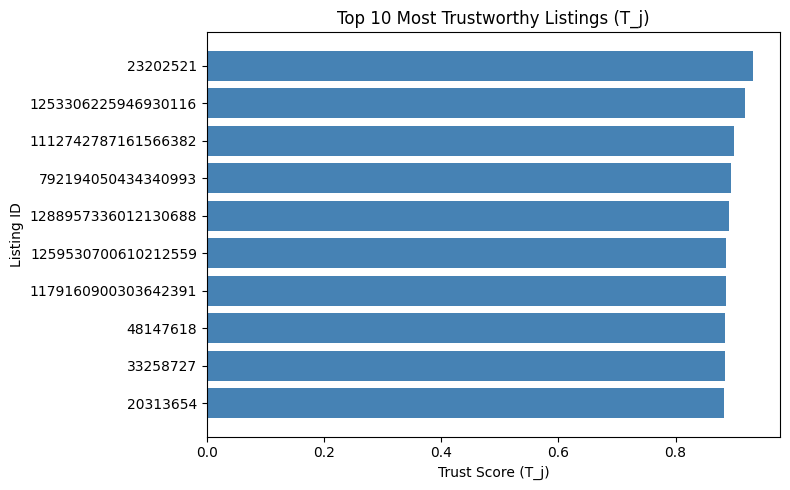

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(top10["listing_id"].astype(str), top10["T_j"], color="steelblue")
plt.gca().invert_yaxis()  # highest at top
plt.title("Top 10 Most Trustworthy Listings (T_j)")
plt.xlabel("Trust Score (T_j)")
plt.ylabel("Listing ID")
plt.tight_layout()
plt.savefig("airbnb_nz_deception_sentiment/figures/top10_trustworthy_listings_bar.png", dpi=300)
plt.show()


In [101]:
import pandas as pd

# top10 already computed (e.g., from previous step)
cols_wanted = [
    "id", "name", "region_name", "room_type", "price",
    "review_scores_rating", "number_of_reviews",
    "estimated_occupancy_l365d", "host_is_superhost"
]

# Join Top-10 with listings metadata
listings_meta = listings[cols_wanted].rename(columns={"id": "listing_id"})
top10_meta = (top10
              .merge(listings_meta, on="listing_id", how="left")
              .sort_values("T_j", ascending=False))

# Light cleaning/conversions for readability
def _money(x):
    # price often like "$123.00" or "123". Keep as string if already formatted.
    try:
        return f"${float(str(x).replace('$','').replace(',','')):,.0f}"
    except:
        return x

for c in ["price"]:
    if c in top10_meta.columns:
        top10_meta[c] = top10_meta[c].apply(_money)

# Save CSV for LaTeX \csvautobooktabular
out_csv = "airbnb_nz_deception_sentiment/figures/top10_trustworthy_listings_with_meta.csv"
top10_meta.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")

# (Optional) quick descriptive check
print(top10_meta[["listing_id","T_j","D_mean","S_mean","n_reviews","review_scores_rating","number_of_reviews","estimated_occupancy_l365d","host_is_superhost"]])

Saved: airbnb_nz_deception_sentiment/figures/top10_trustworthy_listings_with_meta.csv
            listing_id       T_j    D_mean    S_mean  n_reviews  \
0             23202521  0.931539  0.003979  1.000000          1   
1  1253306225946930116  0.917641  0.031464  1.000000          1   
2  1112742787161566382  0.899394  0.019485  1.000000          3   
3   792194050434340993  0.894422  0.007313  1.000000          1   
4  1288957336012130688  0.890879  0.048033  1.000000         28   
5  1259530700610212559  0.885388  0.096436  1.000000          6   
6  1179160900303642391  0.885237  0.020812  1.000000         17   
7             48147618  0.884854  0.100779  1.000000         25   
8             33258727  0.884688  0.004301  1.000000          5   
9             20313654  0.883214  0.073027  0.947368         19   

   review_scores_rating  number_of_reviews  estimated_occupancy_l365d  \
0                  5.00                  5                        255   
1                  5.00       

In [102]:
# Create a new .py file and open it for editing
file_name = "platform_trust_score.py"
with open(file_name, "w") as f:
    f.write("")  # empty file created
print(f"{file_name} created.")

platform_trust_score.py created.


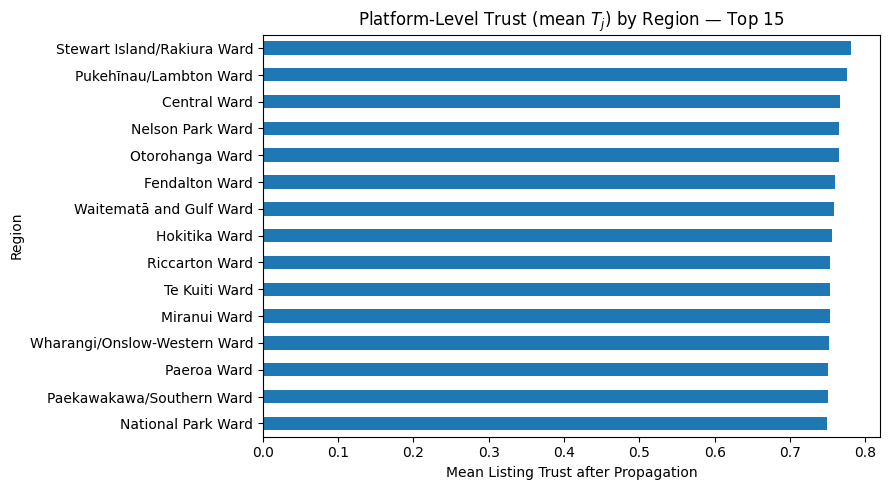

In [105]:
from platform_trust_score import propagate_platform_trust
final_listings, final_reviewers = propagate_platform_trust(
    preds=preds,
    reviews=reviews,
    listings=listings,
    listing_trust=listing_trust,
    sentiment_mode="discrete",
    lam=0.6,
    eps=1e-4,
    max_iter=50,
    outdir="airbnb_nz_deception_sentiment/figures",
    make_region_plot=True
)

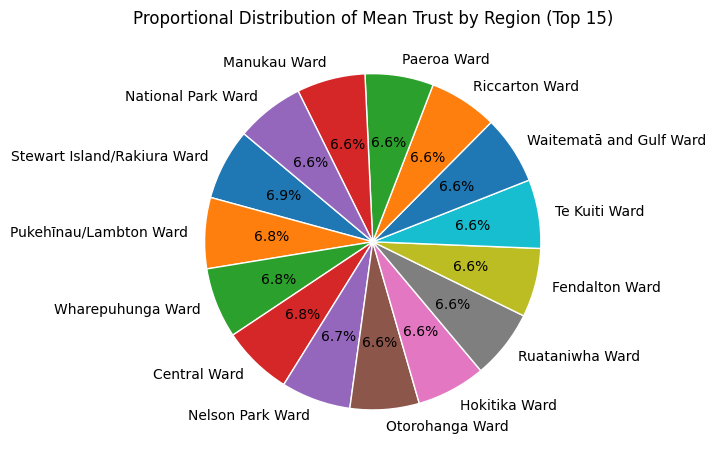

In [116]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Load your trust results ---
# Assuming you already have a DataFrame `listing_trust` with 'listing_id' and 'trust_score'
# and another dataset 'listings' containing 'id' and 'region_name'

# If not, merge your computed trust scores with listings metadata
df = pd.merge(listing_trust, listings[['id', 'region_name']],
              left_on='listing_id', right_on='id', how='left')

# --- Step 2: Compute mean trust per region ---
df_region = (
    df.groupby('region_name', as_index=False)['T_j']
      .mean()
      .rename(columns={'T_j': 'mean_trust'})
)

# --- Step 3: Take top 15 regions ---
top_regions = df_region.nlargest(15, 'mean_trust')

# --- Step 4: Plot pie chart ---
plt.figure(figsize=(7,7))
plt.pie(
    top_regions['mean_trust'],
    labels=top_regions['region_name'],
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Proportional Distribution of Mean Trust by Region (Top 15)")
plt.tight_layout()
plt.savefig("figures/regional_trust_pie.png", dpi=300)
plt.show()

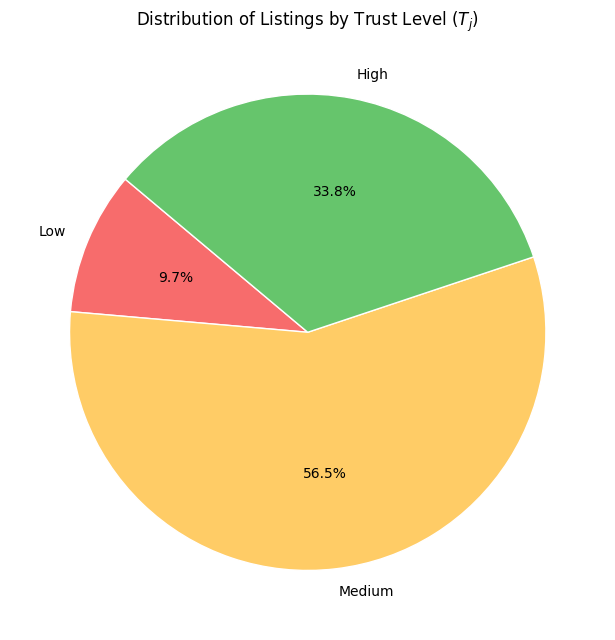

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_listings contains a column 'trust_score'
listing_trust['trust_category'] = pd.cut(
    listing_trust['T_j'],
    bins=[0, 0.6, 0.75, 1.0],
    labels=['Low', 'Medium', 'High']
)

# Count how many listings fall into each category
category_counts = listing_trust['trust_category'].value_counts().sort_index()

# Plot the pie chart
plt.figure(figsize=(6.5,6.5))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#f76c6c', '#ffcc66', '#66c56c'],  # optional aesthetic colours
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Distribution of Listings by Trust Level ($T_j$)")
plt.tight_layout()
plt.savefig("airbnb_nz_deception_sentiment/figures/listing_trust_pie.png", dpi=300)
plt.show()
